In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split, TensorDataset
from torch.optim.lr_scheduler import PolynomialLR, CosineAnnealingLR, CosineAnnealingWarmRestarts, OneCycleLR

# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

import wandb

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

In [2]:
class FourVSTwo(Dataset):
    def __init__(self, N):
        self.X = torch.randint(0, 9, size=(N, 10))
        num2s = torch.count_nonzero(self.X == 2, dim = -1)
        num4s = torch.count_nonzero(self.X == 4, dim = -1)
        labels = torch.tensor(num4s > num2s, dtype=torch.float)
        self.y = labels.reshape(-1, 1)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [3]:
class AttentionModel(pl.LightningModule):
    def __init__(self, hparams):
        super(AttentionModel, self).__init__()
        
        self.lr       = hparams['learning_rate']
        self.batch    = hparams['batch_size']
        self.epoch    = hparams['epoch']
        
        self.query    = nn.Parameter(torch.randn(1,16))
        self.embed_fn = nn.Embedding(10, embedding_dim=16)
        self.key_fn   = nn.Linear(16, 16)
        self.val_fn   = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
        self.head_mlp = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )
        self.save_hyperparameters(hparams)
        self.loss_fn = nn.BCELoss()
    
    def forward(self, X):
        embedX  = self.embed_fn(X)
        keys    = self.key_fn(embedX)
        
        qk      = torch.einsum('ie, bje -> bij', self.query, keys)
        qk      = qk / 16**0.5
        att     = F.softmax(qk, dim=-1)
        vals    = self.val_fn(embedX)
        summary = torch.einsum('bij, bje -> bie', att, vals)[:,0,:]
        
        pred    = self.head_mlp(summary)
        return pred, att, vals
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        p, a, v = self(X)
        loss = self.loss_fn(p, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        X, y = batch
        p, a, v = self(X)
        loss = self.loss_fn(p, y)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        optimizer = optim.RAdam(self.parameters(), lr=self.lr)
        return optimizer

In [4]:
pl.seed_everything(125)

Global seed set to 125


125

In [5]:
torch.set_float32_matmul_precision('medium')

In [6]:
ds_train = FourVSTwo(1000)
ds_val   = FourVSTwo(200)

In [7]:
ds_train[0:2]

(tensor([[6, 2, 6, 4, 4, 5, 3, 8, 1, 0],
         [0, 8, 4, 2, 7, 6, 6, 6, 5, 3]]),
 tensor([[1.],
         [0.]]))

In [8]:
hparams = {
    "learning_rate": 1e-4,
    "epoch": 100,
    "batch_size": 20,
}

In [9]:
dl_train = DataLoader(ds_train, batch_size=hparams['batch_size'], shuffle=True)
dl_val   = DataLoader(ds_val, batch_size=hparams['batch_size'], shuffle=False)

In [10]:
model = AttentionModel(hparams)

In [11]:
model

AttentionModel(
  (embed_fn): Embedding(10, 16)
  (key_fn): Linear(in_features=16, out_features=16, bias=True)
  (val_fn): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
  (head_mlp): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): Sigmoid()
  )
  (loss_fn): BCELoss()
)

In [12]:
wandb_logger = WandbLogger(
    project="MITP2023"
)

wandb: Currently logged in as: axect. Use `wandb login --relogin` to force relogin


In [13]:
trainer = Trainer(
    logger=wandb_logger,
    devices=[0],
    accelerator='auto',
    max_epochs=hparams['epoch'],
    enable_progress_bar=False,
    callbacks=[
        LearningRateMonitor(logging_interval='epoch')
    ]
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(model, dl_train, dl_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | embed_fn | Embedding  | 160   
1 | key_fn   | Linear     | 272   
2 | val_fn   | Sequential | 577   
3 | head_mlp | Sequential | 97    
4 | loss_fn  | BCELoss    | 0     
----------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


In [15]:
wandb.finish()

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
lr-RAdam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█████▇▇▇▆▇▆▅▅▆▇▅▆▅▄▆▆▄▅▄▆▄▄▄▃▂▂▂▁▂▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
val_loss,██████▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▄▄▃▂▂▂▁▁▁▁▁▁▁▁
epoch,99
lr-RAdam,0.0001
train_loss,0.02104
trainer/global_step,4999
val_loss,0.02401


In [16]:
with torch.no_grad():
    X = torch.LongTensor([[4, 7, 2, 2, 2, 1, 3, 4, 0, 6]])
    p, a, v = model(X)

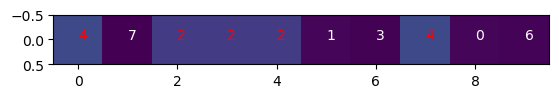

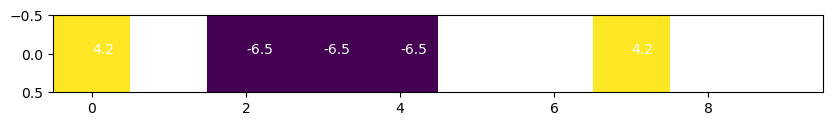

In [17]:
plt.imshow(a[0], vmin=0, vmax=1)
for x, y, d in zip(np.arange(10), np.zeros(10), X[0]):
    plt.text(x,y,int(d), c='r' if d in [4,2] else 'w')
plt.show()

msgs = v[:,:,0]
msgs = np.where(a[0] > 0.1, v[:,:,0], np.nan*v[:,:,0])
plt.imshow(msgs)
for x, y, d in zip(np.arange(10), np.zeros(10), msgs[0]):
    plt.text(x,y,f'{d:.1f}', c='w')
plt.gcf().set_size_inches(20,1)
plt.show()

In [18]:
def decoder(p):
    return torch.tensor(p > 0.5, dtype=torch.float)

In [19]:
result = []
with torch.no_grad():
    for X, y in dl_train:
        p, _, _ = model(X)
        result.extend(torch.flatten(decoder(p) == y).detach().tolist())
    for X, y in dl_val:
        p, _, _ = model(X)
        result.extend(torch.flatten(decoder(p) == y).detach().tolist())

In [20]:
acc = np.count_nonzero(np.array(result) == True) / len(result)
print(f"Accuracy: {acc * 100}%")

Accuracy: 100.0%
